In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150
pd.options.mode.chained_assignment = None  # default='warn'

## Importation des csv

In [199]:
df_olist_customers_dataset = pd.read_csv("data/olist_customers_dataset.csv")
df_olist_order_items_dataset = pd.read_csv("data/olist_order_items_dataset.csv")
df_olist_order_payments_dataset = pd.read_csv("data/olist_order_payments_dataset.csv")
df_olist_order_reviews_dataset = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_olist_orders_dataset = pd.read_csv("data/olist_orders_dataset.csv")
df_olist_products_dataset = pd.read_csv("data/olist_products_dataset.csv")
df_olist_sellers_dataset = pd.read_csv("data/olist_sellers_dataset.csv")
df_product_category_name_translation = pd.read_csv("data/product_category_name_translation.csv")

df_olist_geolocation_dataset = pd.read_csv("data/olist_geolocation_dataset.csv")

Dans le dataset des reviews on transforme la colonne review_comment_title et review_comment_message pour obtenir la longueur du message et du titre

In [200]:
from functions import *

df_olist_order_reviews_dataset['length_comment_title'] = df_olist_order_reviews_dataset["review_comment_title"].apply(lambda x:length_str(x))
df_olist_order_reviews_dataset['length_comment_message'] = df_olist_order_reviews_dataset["review_comment_message"].apply(lambda x:length_str(x))

df_olist_order_reviews_dataset.drop(["review_comment_title","review_comment_message"],axis=1,inplace=True)

df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.groupby(["order_id","review_score"]).agg({"length_comment_title":"max","length_comment_message":"max","review_answer_timestamp":"first"})
df_olist_order_reviews_dataset.reset_index(inplace=True)

In [201]:
# Convertir la colonne 'date' en un objet de type datetime
df_olist_order_reviews_dataset['review_answer_timestamp'] = pd.to_datetime(df_olist_order_reviews_dataset['review_answer_timestamp'])

# Groupby order_id et trouver l'index de la date la plus récente pour chaque order_id
latest_dates = df_olist_order_reviews_dataset.groupby('order_id').review_answer_timestamp.idxmax()

# Utilisez l'index trouvé pour sélectionner les lignes avec les dates les plus récentes
df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.loc[latest_dates]

Dans le dataset des produits on remplace les nan de la colonne product_photos_qty par 0.

On remplace les nan de la colonne product_category_name par unknown.

On remplace les nan de la colonne product_description_lenght par 0.

On drop la colonne product_name_lenght.

In [202]:
df_olist_products_dataset["product_photos_qty"].fillna(0,inplace=True)
df_olist_products_dataset["product_photos_qty"] = df_olist_products_dataset["product_photos_qty"].astype('int8')
df_olist_products_dataset["product_category_name"].fillna("unknown",inplace=True)
df_olist_products_dataset["product_description_lenght"].fillna(0,inplace=True)
df_olist_products_dataset.drop("product_name_lenght",axis=1,inplace=True)


In [203]:
df_product = df_olist_products_dataset.merge(df_product_category_name_translation,how="outer",on="product_category_name")
df_product["product_category_name_english"].fillna("unknown",inplace=True)
df_product.drop("product_category_name",axis=1,inplace=True)

In [204]:
category_mapping = {
"Agro_Industry_and_Commerce": ["agro_industry_and_commerce", "industry_commerce_and_business"],
"Home_and_Comfort": ["air_conditioning", "home_appliances", "home_appliances_2", "home_comfort_2", "home_confort", "housewares", "la_cuisine", "small_appliances", "small_appliances_home_oven_and_coffee","security_and_services", "signaling_and_security"],
"Audio_and_Visual": ["audio", "cds_dvds_musicals", "cine_photo", "dvds_blu_ray", "music", "musical_instruments", "tablets_printing_image"],
"Automotive": ["auto"],
"Baby": ["baby", "diapers_and_hygiene"],
"Food_and_drinks": ["drinks", "food", "food_drink"],
"Computers_and_Electonics": ["computers", "computers_accessories", "electronics"],
"Construction": ["construction_tools_construction", "construction_tools_lights", "construction_tools_safety", "costruction_tools_garden", "costruction_tools_tools", "home_construction"],
"Well-being": ["art", "arts_and_craftmanship","flowers", "party_supplies", "toys", "cool_stuff", "christmas_supplies", "pet_shop", "consoles_games", "luggage_accessories", "watches_gifts", "garden_tools", "books_general_interest", "books_imported", "books_technical"],
"Health_and_Beauty": ["health_beauty","perfumery"],
"Fashion": ["fashio_female_clothing", "fashion_bags_accessories", "fashion_childrens_clothes", "fashion_male_clothing", "fashion_shoes", "fashion_underwear_beach"],
"Sport": ["sports_leisure", "fashion_sport"],
"Miscellaneous": ["market_place", "stationery", "unknown"],
"Communication": ["telephony", "fixed_telephony"],
"Furniture": ["bed_bath_table","furniture_decor", "office_furniture","furniture_bedroom", "furniture_living_room", "furniture_mattress_and_upholstery","kitchen_dining_laundry_garden_furniture"]
}

def reverse_dict(d):
    rev_dict = {}
    for key, value in d.items():
        for val in value:
            rev_dict[val] = key
    return rev_dict

reversed_mapping = reverse_dict(category_mapping)


On regarde le montant total pour chaque categorie

In [205]:
df_categorie = df_olist_orders_dataset.merge(df_olist_order_payments_dataset,how="outer",on="order_id")
df_categorie = df_categorie.merge(df_olist_order_items_dataset,how="outer",on="order_id")
df_categorie = df_categorie.merge(df_product,how="outer",on='product_id')

In [206]:
df_categorie = df_categorie.loc[df_categorie['order_status'] == "delivered"]

In [207]:
df_categorie = df_categorie.groupby("product_category_name_english").agg({"price":"sum","freight_value":"sum","order_item_id":"count"}).reset_index()

In [208]:
df_categorie["montant_total"]=df_categorie["price"] + df_categorie["freight_value"]

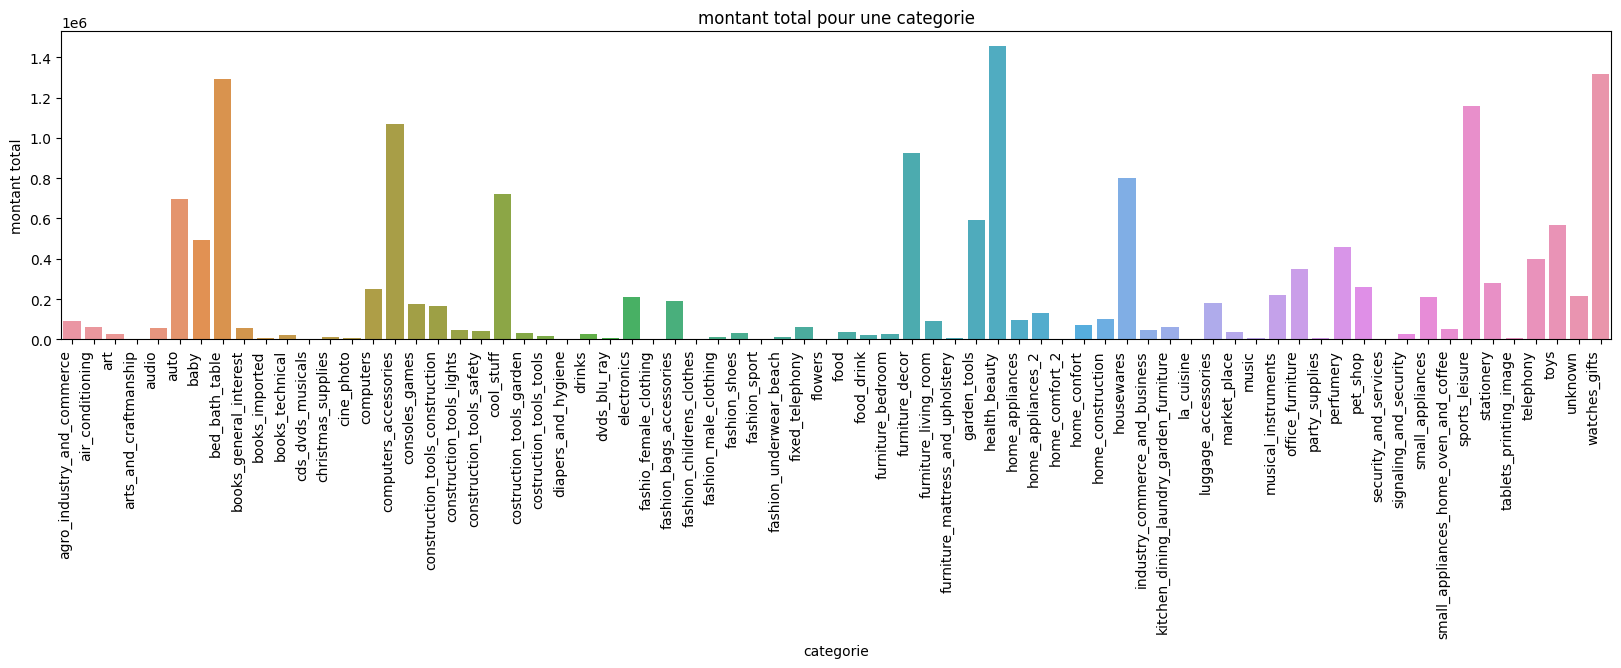

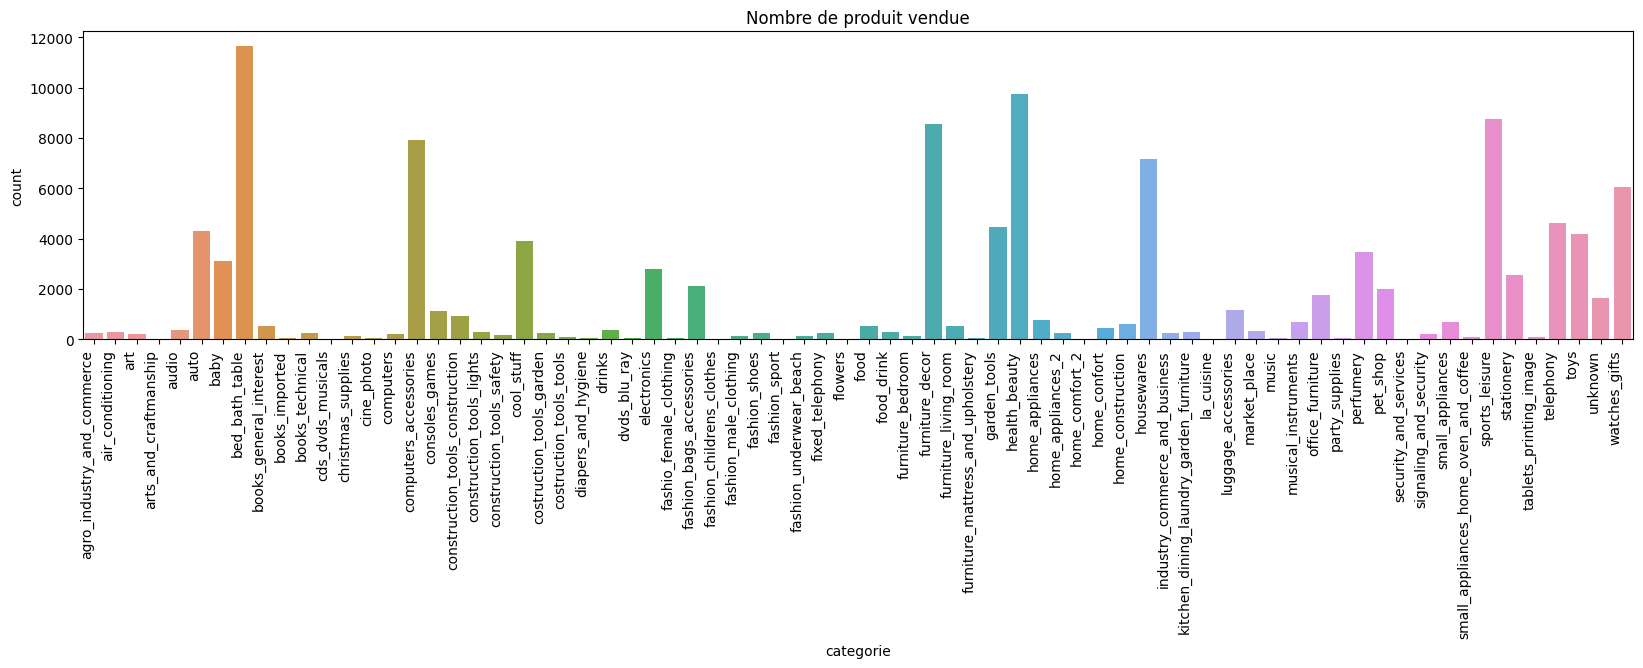

In [209]:
fig, ax = plt.subplots(figsize=(20, 4))

# Premier histogramme
sns.barplot(data = df_categorie , x="product_category_name_english",y="montant_total",ax=ax)
ax.set_title(f"montant total pour une categorie")
ax.set_xlabel("categorie")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=90, ha='right')
ax.set_ylabel("montant total")

plt.show()

fig, ax = plt.subplots(figsize=(20, 4))
# Affichage de la figure
sns.barplot(data = df_categorie , x="product_category_name_english",y="order_item_id",ax=ax)
ax.set_title(f"Nombre de produit vendue")
ax.set_xlabel("categorie")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=90, ha='right')
ax.set_ylabel("count")

plt.show()

In [210]:
df_categorie["product_category_name_english"] = df_categorie["product_category_name_english"].map(reversed_mapping)

In [214]:
df_categorie = df_categorie.groupby("product_category_name_english").agg({"montant_total":"sum","order_item_id":"sum"}).reset_index()

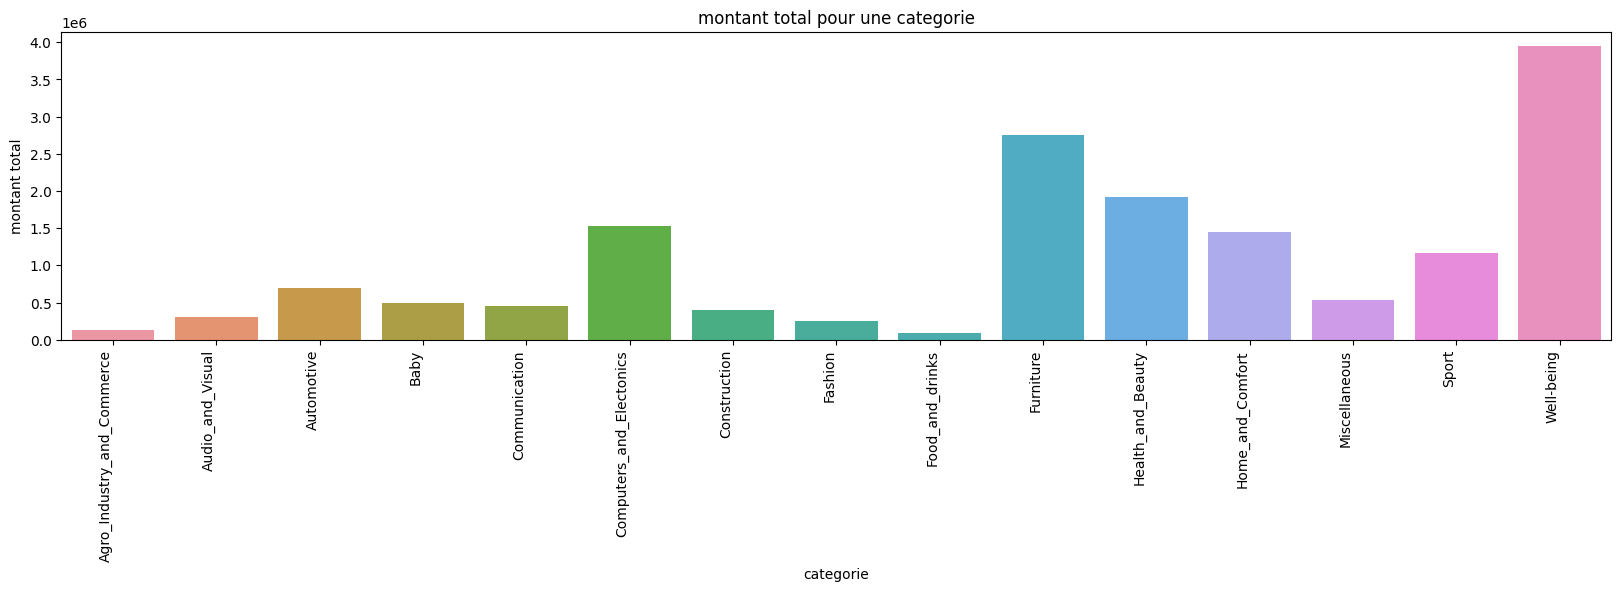

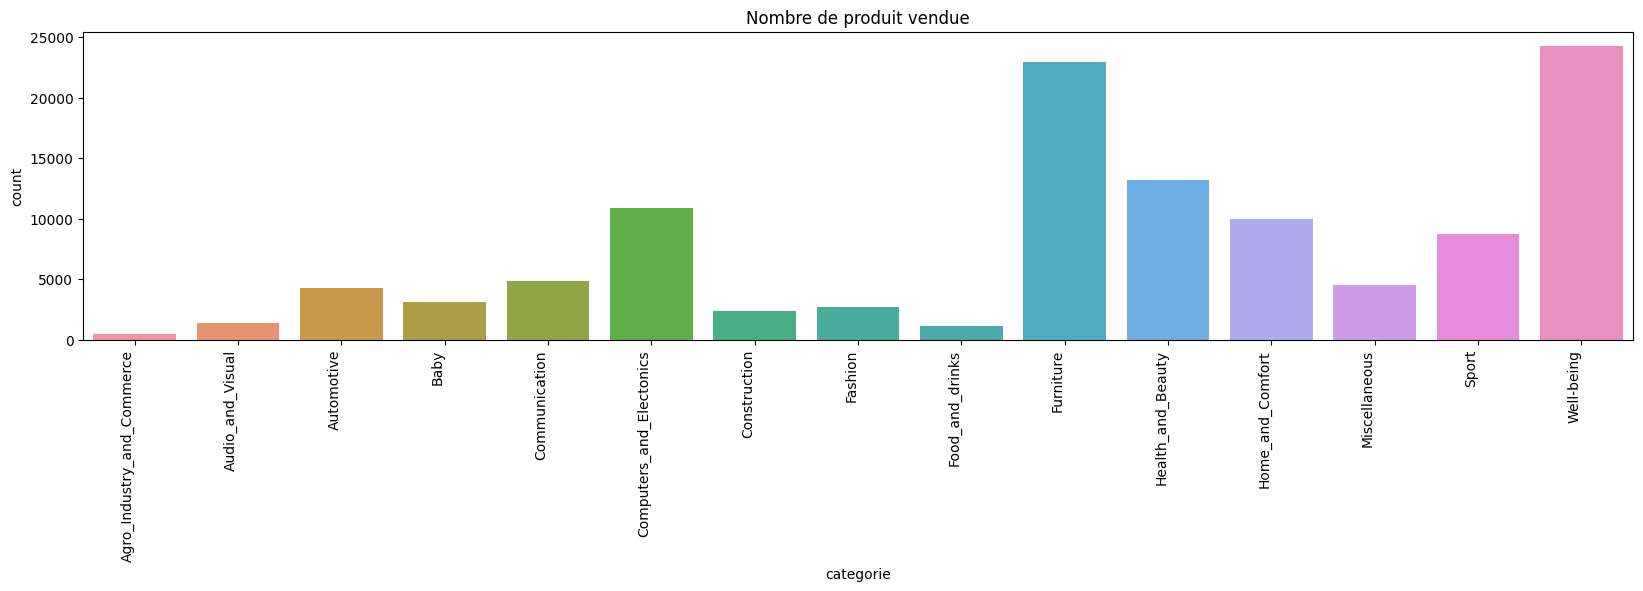

In [215]:
fig, ax = plt.subplots(figsize=(20, 4))

# Premier histogramme
sns.barplot(data = df_categorie , x="product_category_name_english",y="montant_total",ax=ax)
ax.set_title(f"montant total pour une categorie")
ax.set_xlabel("categorie")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=90, ha='right')
ax.set_ylabel("montant total")

plt.show()

fig, ax = plt.subplots(figsize=(20, 4))
# Affichage de la figure
sns.barplot(data = df_categorie , x="product_category_name_english",y="order_item_id",ax=ax)
ax.set_title(f"Nombre de produit vendue")
ax.set_xlabel("categorie")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=90, ha='right')
ax.set_ylabel("count")

plt.show()

In [216]:
df_product["product_category_name_english"] = df_product["product_category_name_english"].map(reversed_mapping)

Dans le dataset des items on groupe par la colonne order_id . Pour obtenir le produit et le vendeur le plus frequent de la commande, le nombre de produit dans la commande et la somme des prix et cout de transport

In [217]:
def get_mode(x):
    return x.mode().iloc[0]
    
df_olist_order_items_dataset = df_olist_order_items_dataset.groupby(["order_id"]).agg({"product_id":get_mode,"seller_id":get_mode,"order_item_id":"count","price":"sum","freight_value":"sum"})
df_olist_order_items_dataset.columns=["product_most_frequent","most_frequent_seller",'nb_items', 'sum_price', 'sum_freight_value']
df_olist_order_items_dataset.reset_index(inplace=True)

Regroupement par order_id dans le dataset payments pour que les order_id soit unique

In [218]:
df_olist_order_payments_dataset = df_olist_order_payments_dataset.groupby(["order_id"]).agg({"payment_type":get_mode,"payment_sequential":"count","payment_installments":"max","payment_value":"sum"})
df_olist_order_payments_dataset.rename(columns={"payment_type":"payment_type_most_frequent"},inplace=True)
df_olist_order_payments_dataset.reset_index(inplace=True)

## Merge des datasets

In [219]:
df_merge = df_olist_orders_dataset.merge(df_olist_order_reviews_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_order_payments_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_order_items_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_customers_dataset,how="outer",on="customer_id")
df_merge = df_merge.merge(df_product,how="left",right_on='product_id',left_on="product_most_frequent")
df_merge = df_merge.merge(df_olist_sellers_dataset,how="outer",left_on="most_frequent_seller",right_on="seller_id")

Visualisation des valeurs manquantes

<AxesSubplot: >

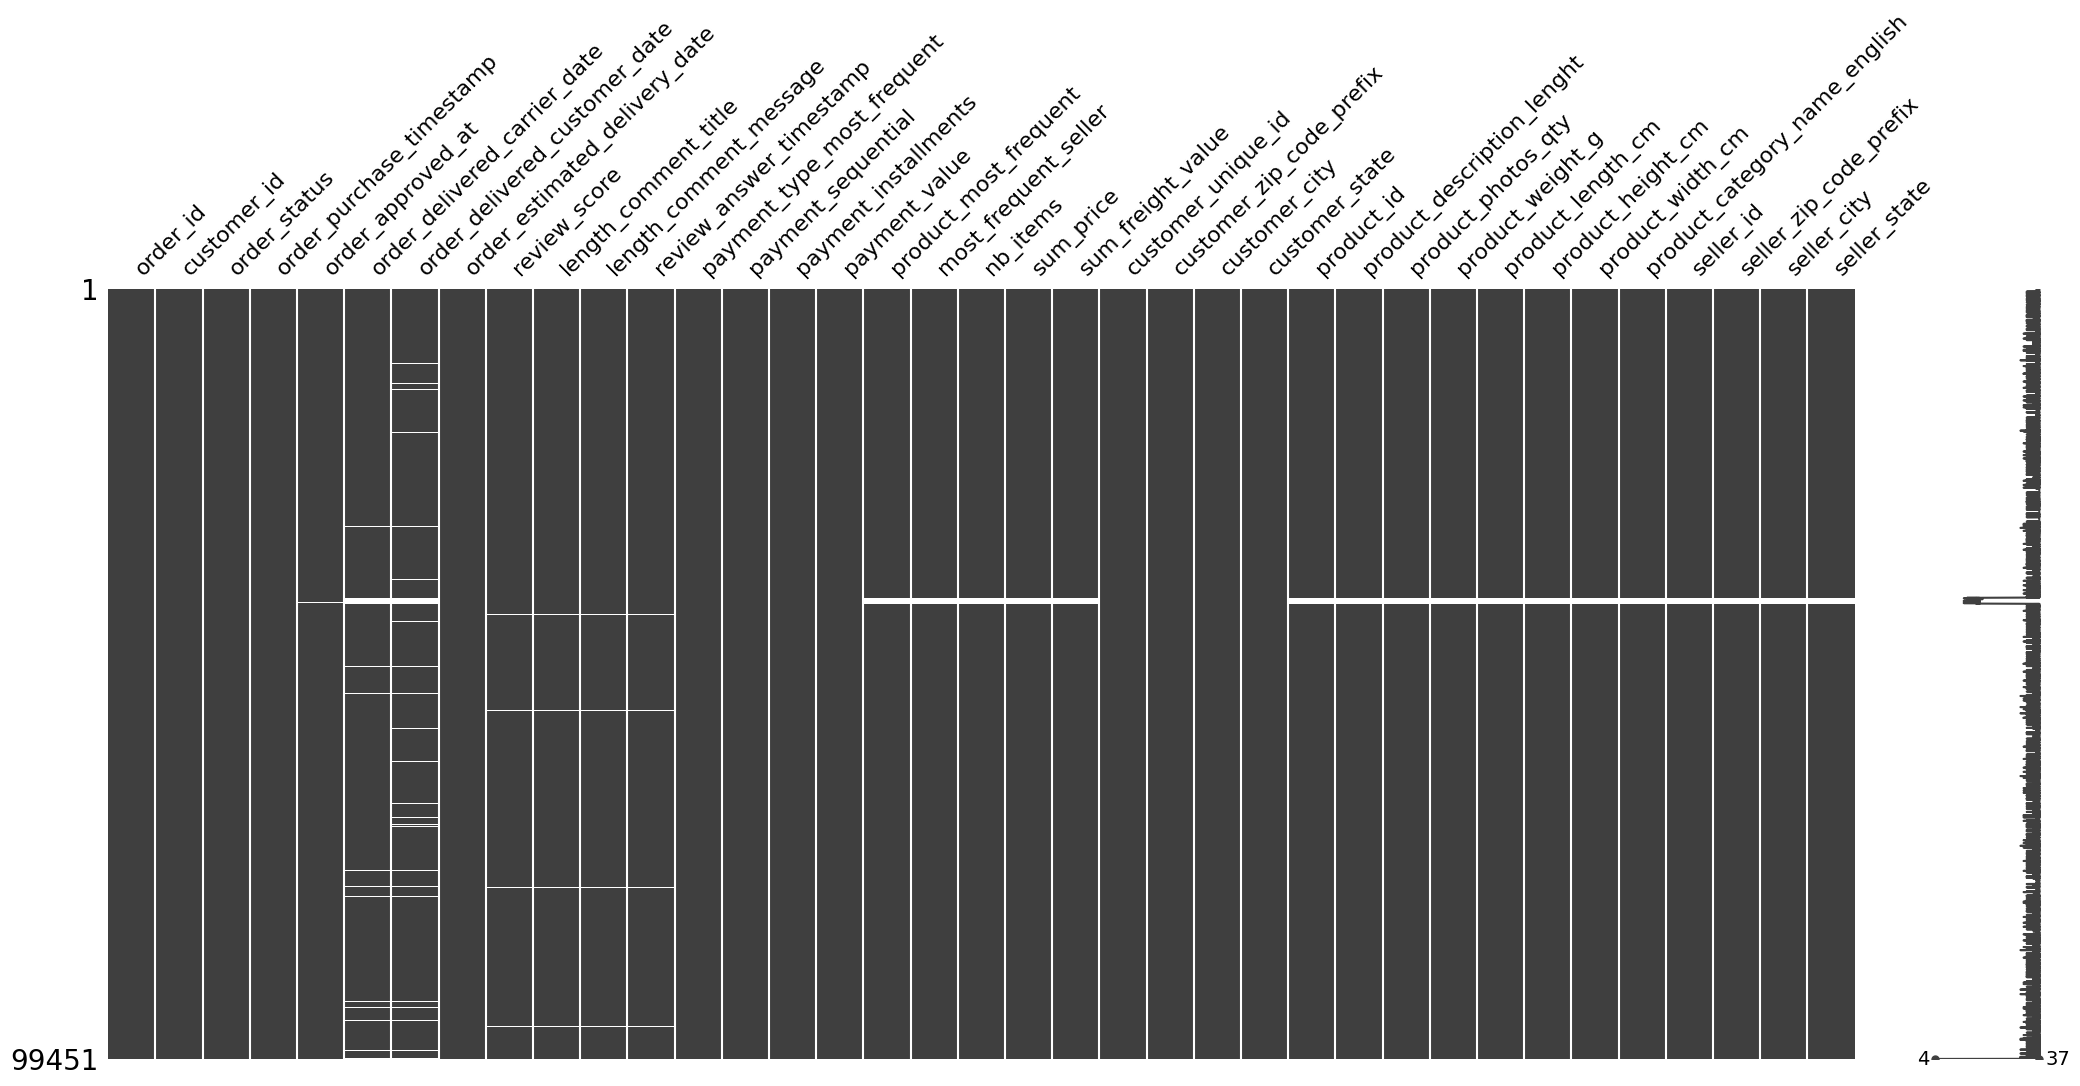

In [220]:
import missingno as msno

msno.matrix(df_merge)

In [221]:
df_merge.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_score', 'length_comment_title', 'length_comment_message',
       'review_answer_timestamp', 'payment_type_most_frequent',
       'payment_sequential', 'payment_installments', 'payment_value',
       'product_most_frequent', 'most_frequent_seller', 'nb_items',
       'sum_price', 'sum_freight_value', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_id', 'product_description_lenght', 'product_photos_qty',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_category_name_english', 'seller_id',
       'seller_zip_code_prefix', 'seller_city', 'seller_state'],
      dtype='object')

In [222]:
columns=["review_score","length_comment_title","length_comment_message","payment_installments","payment_value","nb_items","product_description_lenght","product_photos_qty"]

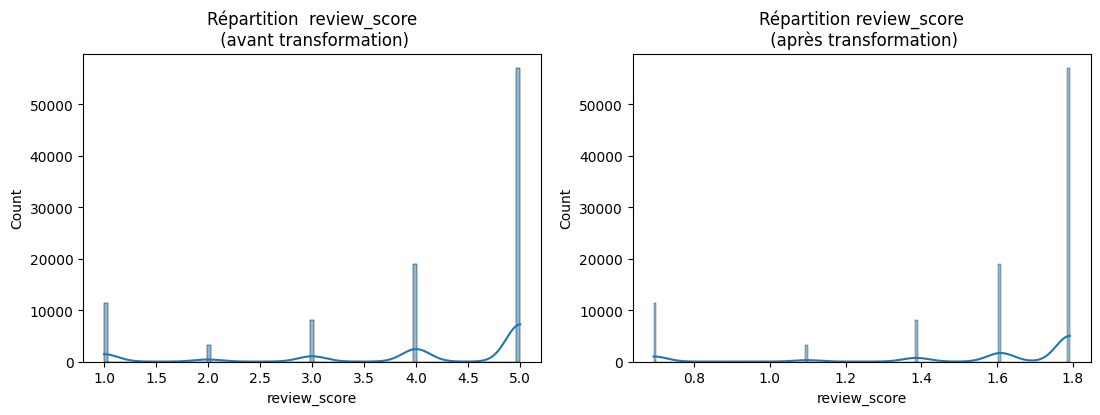

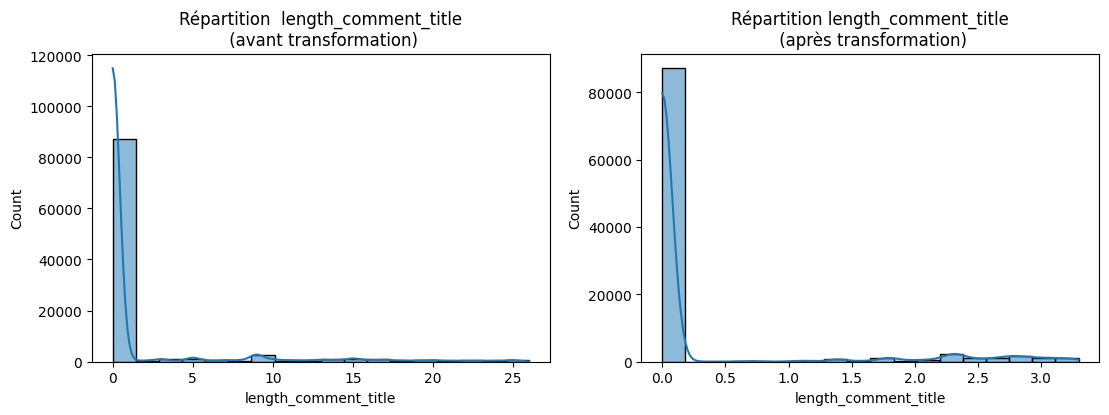

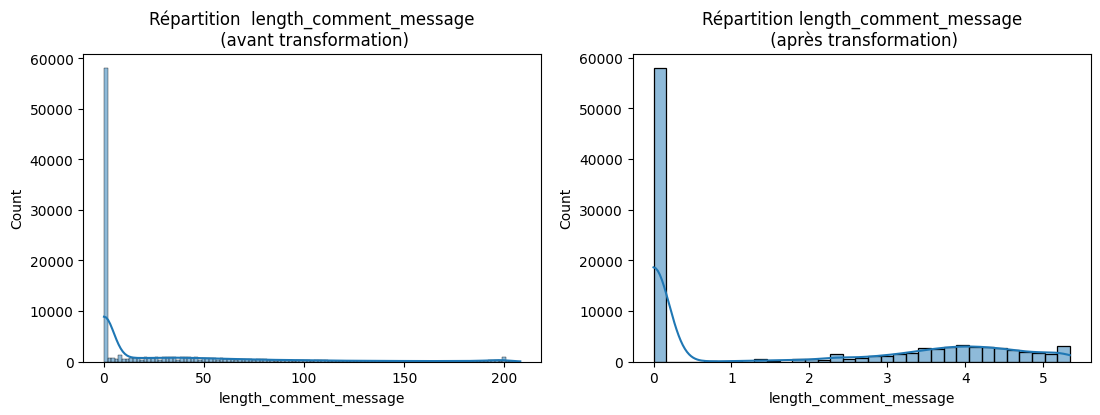

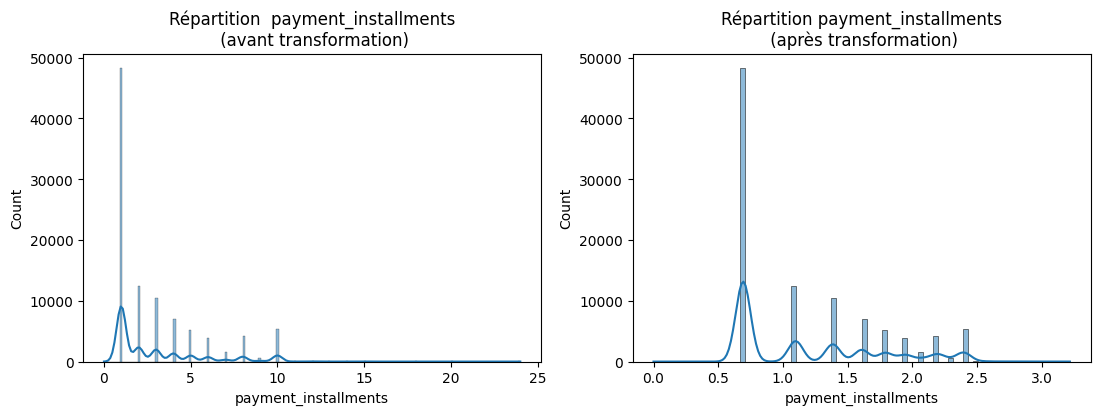

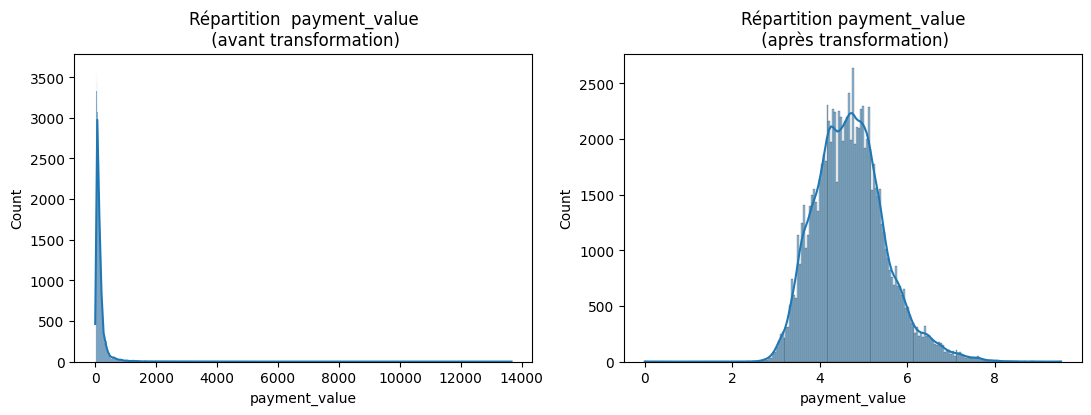

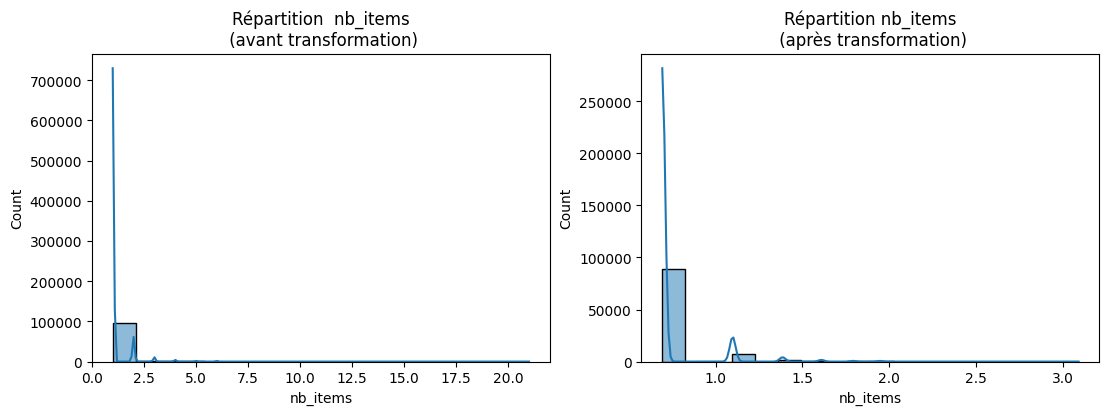

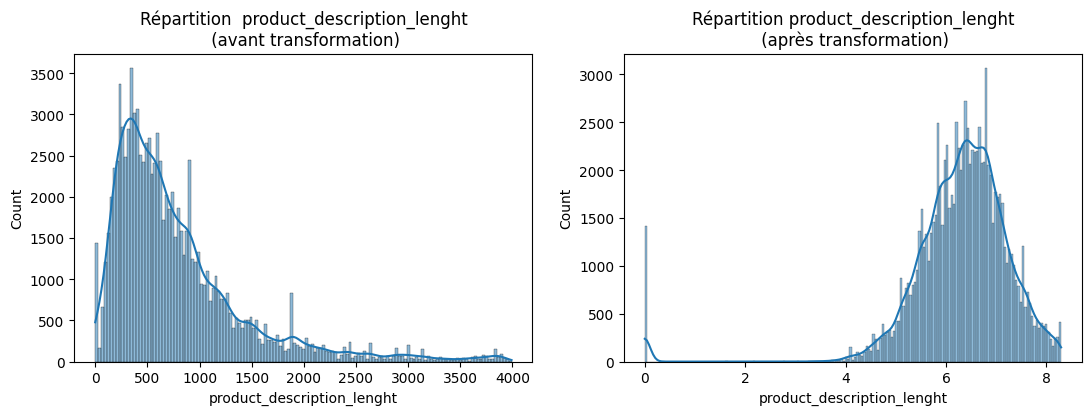

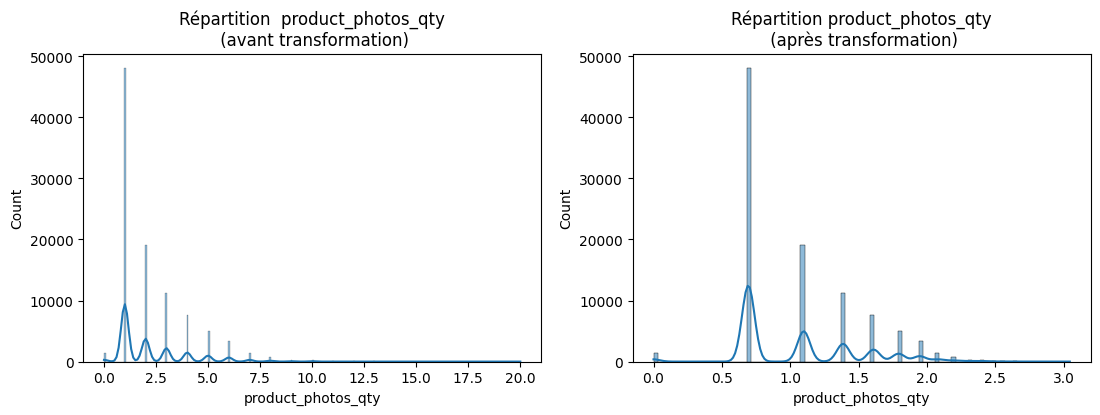

In [223]:

df_log = np.log1p(df_merge[columns])

for col in columns:
    # Création de la figure et des subplots
    fig, ax = plt.subplots(1,2, figsize=(13, 4))

    # Premier histogramme
    sns.histplot(df_merge[col],ax=ax[0], kde=True)
    ax[0].set_title(f"Répartition  {col}\n (avant transformation)")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Count")

    # Second histogramme
    sns.histplot(df_log[col],ax=ax[1], kde=True)
    ax[1].set_title(f"Répartition {col}\n (après transformation)")
    ax[1].set_xlabel(col)
    ax[1].set_ylabel("Count")

    # Affichage de la figure
    plt.show()

In [224]:
df_merge['order_status'].value_counts().to_frame()/len(df_merge)*100

,order_status
delivered,97.010588
shipped,1.113111
canceled,0.628450
unavailable,0.612362
invoiced,0.315733
processing,0.302662
created,0.005028
approved,0.002011


Nous ne conserverons que les order_statuts qui sont "delivered" car les autres catégories sont trop peu représentées

In [225]:
df_merge = df_merge.loc[df_merge['order_status'] == "delivered"]